In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndimage
import tifffile as tf
import glob
import os
import random
from skimage import feature
%matplotlib inline

# Import all relevant packages to run PlantCV 
import cv2 
from plantcv import plantcv as pcv 

In [33]:
def makeImageFromRGB(red_array, green_array, blue_array):
    image = np.dstack((red_array,green_array,blue_array)).astype(np.uint8)
    plt.figure(figsize = (20,20))
    plt.imshow(image)
    plt.axis('off')
    return image

In [34]:
def white_balance(original):   
    
    # load in image file
    pcv.params.debug = ''
    img, path, filename = pcv.readimage(filename=original, mode='native')
    
    # change image to hsv (hue, saturation, value), and seperate brightness
    v = pcv.rgb2gray_hsv(img, channel='v')
    # Ignore lightest part of the image for calculating whitebalance
    img_binary1 = pcv.threshold.binary(v, threshold=160, max_value=255, object_type='dark')
    # find conservative estimate of the leaves
    img_binary2 = pcv.threshold.binary(v, threshold=110, max_value=255, object_type='light')
    # mask image to only look at background of leaves to find white balance
    masked = pcv.apply_mask(img, img_binary1, mask_color='white')
    masked = pcv.apply_mask(masked, img_binary2, mask_color='white')
    
    # change image to grayscale
    masked_binary = pcv.rgb2gray(masked)
    # only keep the darkest points in the image (outside of the leaves)
    masked_binary = pcv.threshold.binary(masked_binary, threshold=125, max_value=255, object_type='dark')
    # remove clusters of pixels that are less than 1000000
    masked_binary = pcv.fill(masked_binary, size=100000)
    
    # identify objects in this gray region
    im2, contours, hierarchy = cv2.findContours(masked_binary,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    # determine how many objects are present and index largest object
    i = np.size(contours)
    final_max = 0
    index = 0
    # loop through objects to find the largest one and index which object that is
    for maximum in range(i):
        temp_max = np.shape(contours[maximum])[0]
        if temp_max > final_max:
            final_max = temp_max
            index = maximum
    
    # in the largest object, select x/y coordinates at random and use this as white balance 
    random_xy = random.randrange(0, np.shape(contours[index])[0])
    x = int(contours[index][random_xy][0][0])
    y = int(contours[index][random_xy][0][1])
    white_balance_corrected = pcv.white_balance(img=img, roi=(x,y,100,100))
    original = original.replace(".JPG", "_wb.JPG")
    pcv.print_image(white_balance_corrected, original)

    return

In [ ]:
def masking_jpgs(tiff_file, src, dst):
    raw, fname = os.path.split(tiff_file)
    bname = os.path.splitext(fname)[0]
    sname = bname.split('_')[0]
    x,y = bname.split('_')[2:4]
    x,y = int(x[1:]), int(y[1:])
    
    leaf = tf.imread(tiff_file)
    leaf[leaf > 0] = 200
    w,h = leaf.shape
    pcv.params.debug = 'plot'
    #white_balance(src + sname + '.JPG') 
    pic = Image.open(src + sname + '_wb.JPG')
    individual = pic.crop((y,x,y+h,x+w))
    
    img = np.asarray(individual).copy()
    r,g,b = img[:,:,0],img[:,:,1],img[:,:,2]
    r[leaf == 0 ] = 255
    g[leaf == 0 ] = 255
    b[leaf == 0 ] = 255
    area = np.sum(img > 0)
    
    mask = np.dstack((r,g,b)).astype(np.uint8)
    mask_copy = mask
    mask = Image.fromarray(mask)
    mask.save(dst+ bname + '.jpg')
    
    
    #two plots
#     plt.hist(hist_plot.ravel(),256,[0,256]); plt.show()

    color = ('b','g','r')
    for i,col in enumerate(color):
        histr = cv2.calcHist([mask_copy],[i],None,[254],[1,255])
        histr = histr / area
        print(np.sum(histr), i)
        plt.plot(histr,color = col)
        plt.xlim([0,150])
    plt.show()
    return img

In [ ]:
# Path to the split leaves (greyscale TIFFs)
lsrc = '/Users/15099/Desktop/GitHub/imagening_amaizeing/split_grayscale/'

# Path to the scaned leaves (original colored JPGs)
ssrc = '/Users/15099/Desktop/GitHub/imagening_amaizeing/leaves/'

# Path to save the colored masks
dst = '/Users/15099/Desktop/GitHub/imagening_amaizeing/masks/'

0.16744923053208122 0
0.23295977668845988 1
0.13545486847869256 2


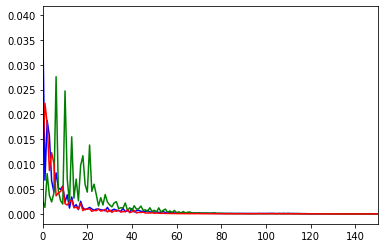

0.17638520696081264 0
0.21874552387951687 1
0.12457226098922733 2


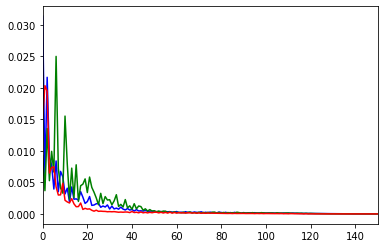

0.17263343184057178 0
0.20348991257509372 1
0.12388449776671359 2


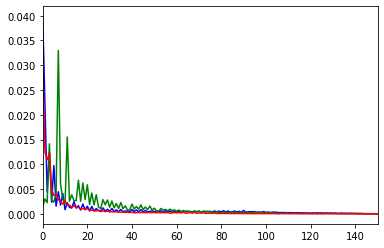

0.20404648436209355 0
0.2506780644209739 1
0.17320380968211888 2


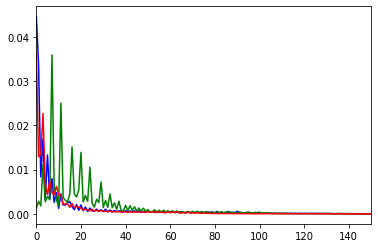

0.22824714172277913 0
0.2628894077062039 1
0.1591053151691205 2


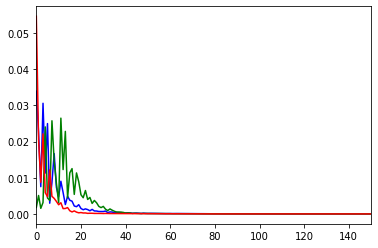

0.24785403946748746 0
0.2792419480817102 1
0.21835164843828841 2


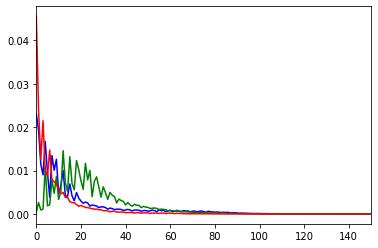

0.19892692152132524 0
0.22845137406957397 1
0.18773031200884957 2


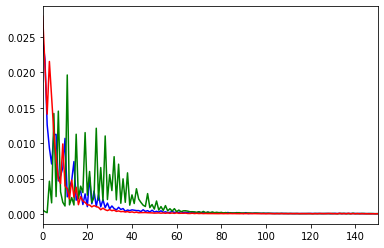

0.19490605355206972 0
0.24019629395056727 1
0.1927414253591441 2


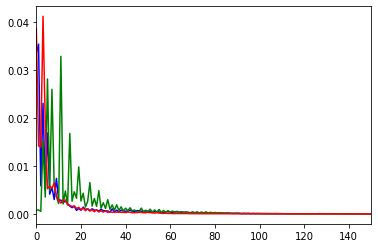

0.17735754600262943 0
0.19444408905065352 1
0.14956678971549947 2


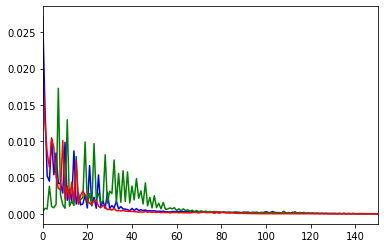

0.19555794265140827 0
0.19806036310321898 1
0.1752232896678349 2


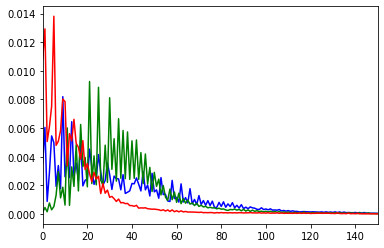

0.14273054874734512 0
0.22157275600385679 1
0.1537625062688499 2


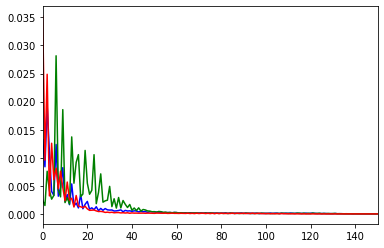

0.20487695294631875 0
0.25165841609319245 1
0.21698771054209826 2


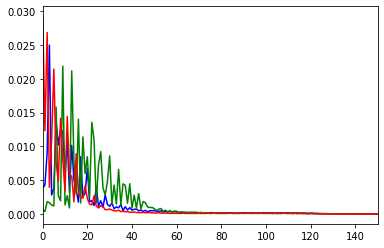

0.21186631998123265 0
0.223527159479553 1
0.19587399836341968 2


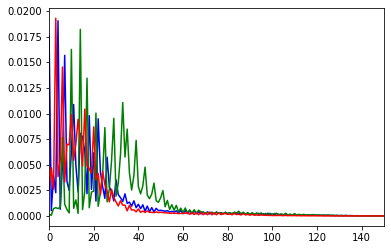

0.1813313405503257 0
0.23739270153465528 1
0.15834398912702055 2


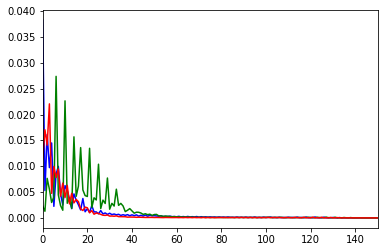

0.22216326196019548 0
0.22299150997092906 1
0.21816993369788676 2


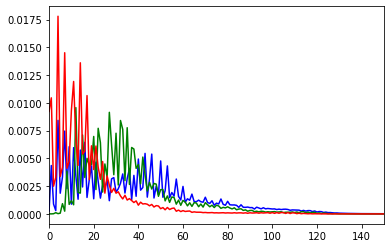

0.1878602775343427 0
0.22462725649891604 1
0.1744984405096598 2


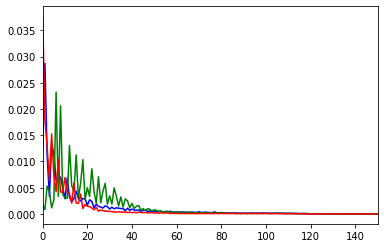

0.23191915037616326 0
0.23217760374288507 1
0.23132009483665494 2


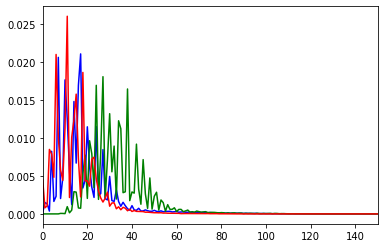

0.2221635278913525 0
0.24154094833435194 1
0.21628708840462815 2


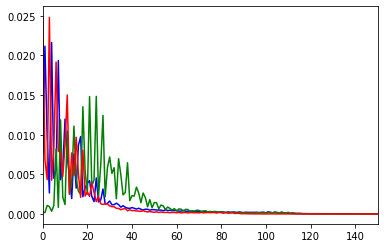

0.20646959482661598 0
0.20751419729693887 1
0.2035847939067347 2


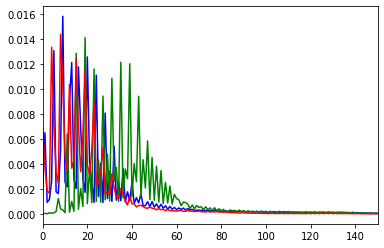

0.2192527300986753 0
0.25096122874344357 1
0.19244290696954222 2


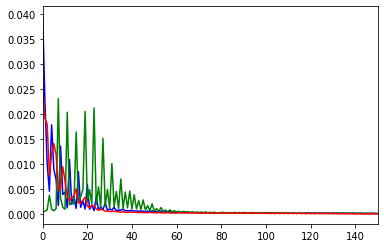

0.2216600474449651 0
0.2430702187174021 1
0.22038265978391547 2


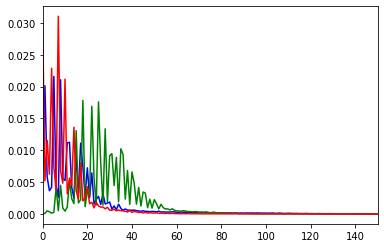

In [ ]:
tiffs = sorted(glob.glob(lsrc + '*.tif'))
for tiff in tiffs:
    total = masking_jpgs(tiff, ssrc, dst)

In [ ]:
total = masking_jpgs(tiff, ssrc, dst)

color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([total],[i],None,[254],[1,255])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

In [ ]:
hist = cv2.calcHist([total],[0],None,[256],[0,256])
hist_plot = cv2.imread(ssrc + sname + ".JPG",0)

In [ ]:
l_name = 'IMAG0044_l0_x945_y106.tif'
x,y = os.path.splitext(l_name)[0].split('_')[2:4]
x,y = int(x[1:]), int(y[1:])
s_name = l_name.split('_')[0]
print(s_name)
print(x,y)

In [ ]:
leaf = tf.imread(lsrc+l_name)
leaf[leaf > 0] = 200
plt.figure(figsize=(40,12))
plt.imshow(leaf, cmap=plt.cm.gray)
plt.axis('off')

In [ ]:
w,h = leaf.shape

pic = Image.open(ssrc + s_name + '.JPG')

individual = pic.crop((y,x,y+h,x+w))
plt.figure(figsize=(20,20))
plt.imshow(individual)

In [ ]:
img = np.asarray(individual)

In [ ]:
r,g,b = img[:,:,0].copy(),img[:,:,1].copy(),img[:,:,2].copy()

In [ ]:
r[leaf == 0 ] = 255
g[leaf == 0 ] = 255
b[leaf == 0 ] = 255

In [ ]:
mask = makeImageFromRGB(r,g,b)

In [ ]:
mask = Image.fromarray(mask)
mask.save(dst+s_name+'.jpg')